<a href="https://colab.research.google.com/github/Yoon0527/AIFFEL_Going_Deeper/blob/main/%5BGD_13%5D_About_Detection(single_stage).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [GD-13] 멀리 있지만 괜찮아


## 13.1 Dlib 얼굴 인식의 문제점
지금까지 배운 Face Detection을 위한 방법은 Dlib 라이브러리를 이용해서 Face Landmark를 찾아내는 것이었다. 하지만 이 방법만으로는 충분하지 않았음.
> **Q1. Dlib 라이브러리를 이용해 Face Landmark를 찾아낼 때의 문제점은 무엇이었나요?**
>
> A1. 얼굴을 잘 못 찾는다.<br>
> A2. 동영상을 처리하기엔 너무 느리다.<br>
A3. 얼굴각도, 방향, 크기 등의 변화에 취약하다.<br>
A4. 그 외에도 많은 문제점을 발견할 수 있다.

작아지고 빨라지는 것이 중요한 이유는 우선 비대면 인증 수단으로 얼굴 인식이 보편적으로 사용되기 시작했다는 점을 들 수 있다. 얼굴 인식을 위해 딥러닝 서버 구동이 필요한 모델을 활용할 수 있을까?

서버로 이미지를 보낸 후 처리하는 방식은 **네트워크 비용 + 서버 비용 + 인터넷 속도**의 영향을 고려하지 않을 수 없다. 따라서 네트워크 상황과 무관하게 항상 동작해야 하는 핸드폰 인증 수단으로는 적합하지 않다. 그렇다면 edge device를 바로 이용하려면 어떻게 해야할까?

핸드폰에 모델을 올리려면 weight가 작은 모델이 관리에 유리하다. 하지만 일반적으로 작은 모델은 성능이 떨어지기 때문에 어떻게 보완할 수 있을지 고민이 시작된다.

국내 IT 대기업들도 관련 연구를 활발히 진행하고 있다.
* 카카오: https://tech.kakaoenterprise.com/63
* 네이버: https://github.com/clovaai/EXTD_Pytorch

Face detection에서 많은 시간이 드는 요소는 Sliding Window이다. 그러므로 Sliding window를 버려야 빨라진다. 따라서 2-stage 방식의 detection은 좋은 선택이 아니다.

또한 연산의 병렬화가 가능해야 한다. 컴퓨터의 GPU에서는 병렬화가 가능하지만 핸드폰에서도 병렬화가 가능한지에 대해 생각해보면, 크게 안드로이드와 아이폰의 경우로 나누어 생각해볼 수 있다.

안드로이드에서는 MLKit, 아이폰에서는 CoreML이라는 라이브러리를 통해 병렬화를 할 수 있다. 하지만 제한이 많기 때문에 TFLite라는 도구를 이용해 훈련된 모델을 이용하기도 한다.

위 방법으로도 해결이 안되면 어렵더라도 다른 방법을 생각해봐야 한다. 우선 직접 병렬 프로그래밍 라이브러리를 만들어볼 수 있겠지만, 난이도가 너무 높다. 비교적 쉬운 방법으로는 SIMD 병렬 프로그래밍이나 OpenCL, Android: Open GLES 등 병렬화 도구를 사용하는 방법이 있다.

하지만 무엇보다도 적은 파라미터 수로도 정확한 성능을 가지는 모델을 설계하는 게 중요할 것이다.
****


## 13.2 Single Stage Object Detection
2-stage Detector는 물체가 존재하는 bounding box를 먼저 찾은(localization) 후에 bounding box를 분류(classification)하는 두 가지 과정을 순차적으로 거쳤기 때문에 속도가 느렸다.

반면 single stage detector는 localization과 classification을 동시에 수행하기 때문에 2단계를 거치는 2-stage detector보다는 속도가 빠르지만, 정확도가 낮다는 단점이 있다.

* 2-Stage Detector와 1-Stage Detector 모델 종류

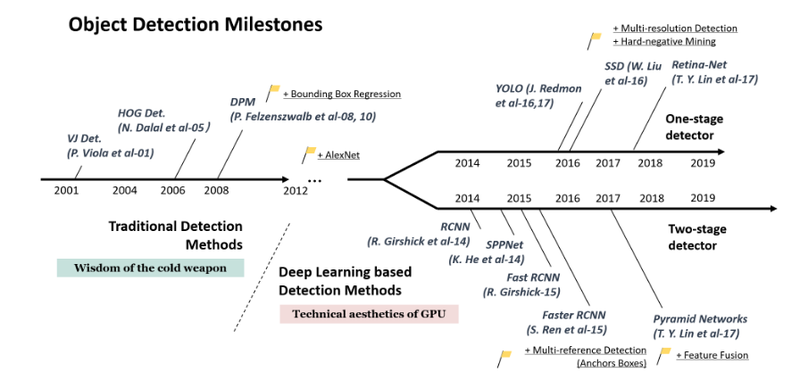

****
## 13.3 YOLO (1) YOLO v1의 등장
YOLO: You Only Look Once

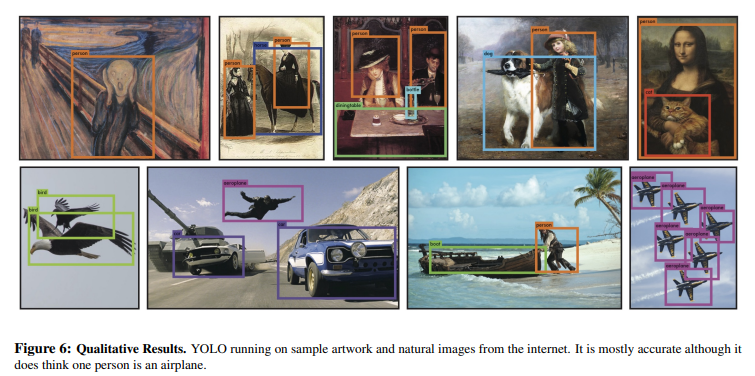

## 13.4 YOLO (2) YOLO v1의 원리
> 논문: https://arxiv.org/pdf/1506.02640.pdf

### YOLO의 특징
1. You Only Look Once
  * 전체 이미지를 보는 횟수가 1회라는 것을 의미한다. YOLO는 클래스에 대한 정보와 주변 정보까지 한 번에 학습하고 처리한다. 따라서 배경 오류가 적고 일반화 성능이 좋다.

2. Unified
  * Localization과 Classification을 동시에 수행한다.(single stage) YOLO는 이미지를 신경망에 넣어주기만 하면 바로 detection이 가능하다.

3. Real-Time
  * 기본적인 YOLO 모델로는 45FPS(초당 프레임수), 빠른 버전은 150FPS까지 성능을 보인다.(참고로 Fast R-CNN은 0.5FPS, DPM은 30FPS의 성능을 가지고 있다.) 따라서 스트리밍 비디오에서도 실시간으로 객체를 detection할 수 있다.

이 외에도 object detection을 회귀 문제로 관점을 전환했고, 여러 도메인에서 object detection이 가능하다는 특징이 있다.
****
### RCNN과 YOLO

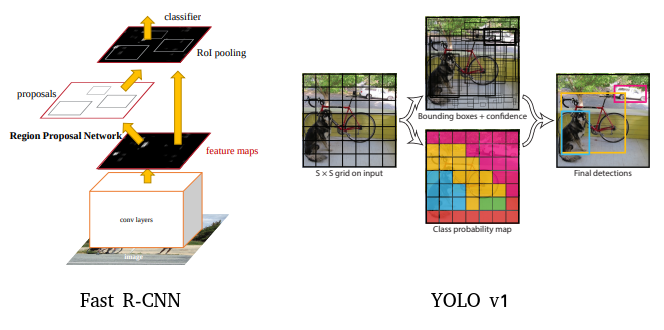

RCNN(2-stage detector)와 YOLO의 차이는
* RCNN 계열의 가정: 객체가 존재할 것 같은 곳을 backbone network로 표현할 수 있다. -> Region Proposal Network(RPN)
* YOLO v1의 가정: 이미지 내의 작은 영역을 나누면 그 곳에 객체가 있을 수 있다. -> grid 내에 객체가 존재한다.

따라서 YOLO v1에서 grid는 고정되고, **각 grid 안에 객체가 있을 확률**이 중요하게 된다.

> **Q2. YOLO v1에서 입력 이미지 크기가 448x448이고 출력 feature map이 7x7일 경우, 한 개의 출력 grid box(1x1 크기)가 의미하는 사이즈는 얼마일까요?**
>
> A. 448 / 7 = 64이므로 grid box 사이즈는 64x64이다.
****
### YOLO의 grid cell

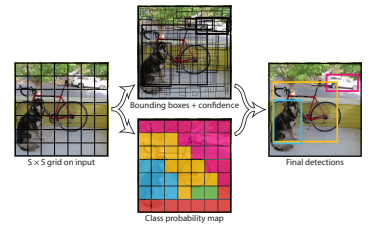

YOLO는 이미지를 S x S grid로 나누고, box regression 단계와 각 클래스마다 probability map을 구하는 단계가 동시에 병렬적으로 수행된다.

논문에서는 입력 이미지를 7x7 grid로 나누고, 각 grid cell마다 예측하는 bound box(bbox)를 2개, 총 클래스의 수는 20으로 정했다.

각 grid cell은 bounding box와 c개의 class 확률을 예측한다.

각 bounding box(B)는 x, y, w, h, confidence score를 예측한다. x, y는 bbox의 중심 좌표이고 w와 h는 너비와 높이이다. 주의할 점은 w와 h는 입력 이미지를 bbox의 너비와 높이를 나눠서 normalize한 값으로 0과 1사이의 값을 가진다는 것이다.

confidence score는 box가 객체를 포함하고 있는지를 모델이 얼마나 자신 있는지, 그리고 박스가 예측하는 것이 얼마나 정확한지를 보여준다.

만약 grid cell이 객체를 포함하지 않으면 confidence score는 0이다. grid cell이 객체를 정확히 포함하고 있다면 confidence score가 예측된 box와 ground truth box 사이의 IoU와 같도록 하는 것이 좋다.

c개의 조건부 클래스 확률 P는 grid cell이 사물을 포함할 때 bbox 안의 객체가 i번째 클래스에 속할 확률이다. bounding box의 개수와 상관 없이 각 grid cell의 확률만 예측한다.

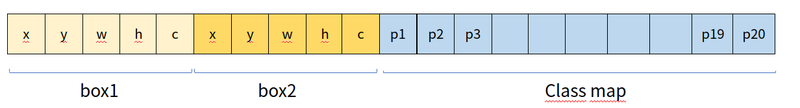

> **Q3. 1개의 7x7 grid 당 2개의 bounidng box(BBox) 와 20개 클래스를 예측하는 YOLO 를 만들고 싶은 경우, output tensor의 크기와 이를 flatten했을 때의 크기는 무엇인가요?**
>
> A. output tensor의 크기는 7 x 7 x (5 x 2 + 20)이며, 이를 flatten하면 1470이다.

위 이미지에서는 자전거를 포함하는 grid가 많다. 이런 경우는 해당 grid의 bbox가 모두 자전거라고 예측할까? 학습이 잘 된 경우는 해당 grid들이 모두 비슷한 크기로 자전거의 bbox를 잡는다. 여기서 동일한 객체를 잡는 bbox가 많아진다는 문제가 생긴다.

이 때는 NMS(Non-Maximum Suppression)와 같은 기법을 이용한다. 비-최대 억제라고도 불리는 NMS 기법은 object detector가 예측한 여러 개의 bounding box 중 정확한 bounding box만을 선택하는 기법이다.

* NMS의 알고리즘
1. 하나의 클래스에 대한 높은 confidence score 순서대로 bbox를 정렬한다. confidence score가 특정 threshold를 넘지 않는 것은 제거한다.
2. 가장 높은 Confidence Score의 bbox와 겹치는 다른 bbox를 비교하여 IoU가 threshold보다 높으면 겹치는 bbox를 목록에서 제거한다. 두 bbox의 IoU가 높다는 것은 같은 객체를 detect하고 있다는 의미이기 때문이다.
3. 1과 2의 과정을 반복해 마지막으로 남은 bbox를 반환한다.
4. 각 클래스에 대해 위의 과정을 반복한다.

NMS 알고리즘을 적용하면 아래의 그림과 같이 겹쳐 있는 bounding box 중 정확한 bounding box만 표시된다.

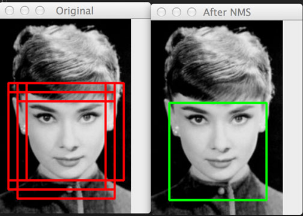

YOLO의 목표는 grid에 포함되는 객체를 잘 잡아내는 것이다. 즉, grid cell에 속하는 객체를 검출할 책임이 있는 것인데, 따라서 1개 grid에 귀속된 bbox 정보(x, y, w, h)의 학습 목표는 bbox의 ground truth와 최대한 동일하도록 학습되는 것이다. 학습 목표가 제대로 이루어졌는지를 확인하려면 객체 인식 모델의 성능 평가 도구인 IoU(Intersection over Union)를 사용한다.

> IoU의 개념: https://ballentain.tistory.com/12
***
### YOLO의 네트워크 구조
YOLO의 네트워크 구조는 아래 그림과 같이 24개의 Conv 레이어와 2개의 Fully connected layer로 구성되어 있다.

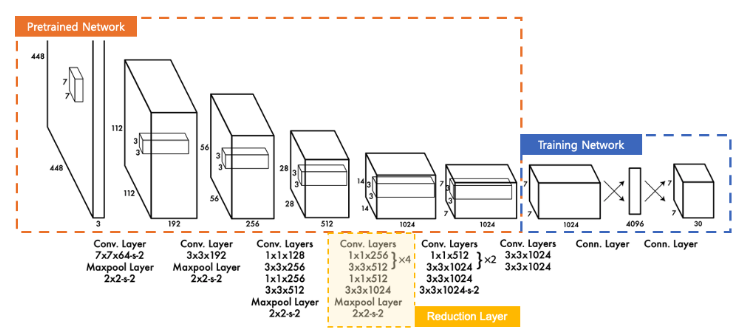

모델 구조의 앞부분(pretrained)은 ImageNet의 1000개 클래스 데이터셋을 가지고 사전학습한 GoogLeNet 모델이다. 사전학습을 위해 20개의 Conv 레이어와 average pooling 레이어와 fully-connected 레이어를 사용하였다. 그러나 GoogLeNet의 Inception 모듈 대신 1x1 reduction 레이어를 사용해 연산량을 감소시켰다.

detection을 위해 사전학습된 모델에 4개의 Conv 레이어와 2개의 FC 레이어를 추가하였고, PASCAL VOC 데이터셋으로 fine-tuning하였다. fine-grained 이미지를 얻기 위해 원래의 224x224 이미지의 2배인 448x448 이미지를 사용했다고 한다.

마지막 레이어는 Class 확률과 bbox 좌표를 학습하고 예측하여 S x S x(B*5+c)크기의 텐서로 예측값이 출력된다.

### YOLO의 Inference 과정

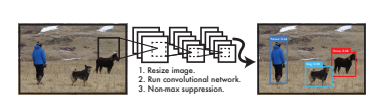

Inference를 할 때는 조건부 클래스 확률 P(Class|Object)를 각 box의 confidence 예측값과 곱해 각 box의 클래스별 confidence score(class-specific confidence score)를 얻을 수 있다. 각 score는 box의 클래스의 확률과 예측된 box가 사물을 얼마나 잘 예측하는지를 보여준다.

이 과정을 모든 bbox에서 시행하면, 한 이미지에서 예측한 클래스별 confidence score의 개수는 7 * 7 * 2 = 98개이다. 이 98개의 클래스별 confidence score에 대해 20개의 class를 기준으로 NMS를 하여 object에 대한 class와 bounding box location을 결정할 수 있다.

## 13.5 YOLO (3) YOLO v1의 성능


### YOLO v1의 loss 함수
YOLO의 loss는 bbox의 위치 예측과 관련된 localization loss와 클래스 예측과 관련된 classification loss가 있으며, 두 loss 모두 SSE(sun-square error)를 기반으로 한다. 그런데 SSE는 이 두 loss를 동일하게 가중치를 준다. 이런 상황은 이상적이 아니다. 뿐만 아니라 이미지 내 대부분의 grid cell에 객체가 없을 경우가 일반적인데, 이런 경우에는 confidence score가 0에 가깝게 된다. 이는 모델의 불균형을 초래한다.

이런 문제를 해결하기 위해 bbox의 좌표에 대한 loss를 증가시키고, 객체가 없는 box의 confidence 예측값의 loss는 값소시켰다. 이를 위해 λcoord와 λnoobj라는 두 개의 하이퍼파라미터를 사용했다.

뿐만 아니라 SSE는 큰 bbox와 작은 bbox의 loss를 모두 동일한 가중치로 계산한다. 그러나 작은 bbox가 큰 bbox보다 조그마한 위치 변화에도 더 민감하다. 이를 개선하기 위해 bbox 너비와 높이에 square root를 취해주었다.

* YOLO의 loss 함수

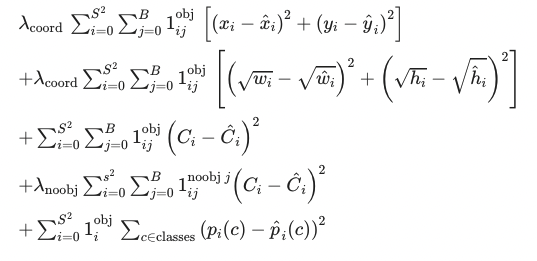

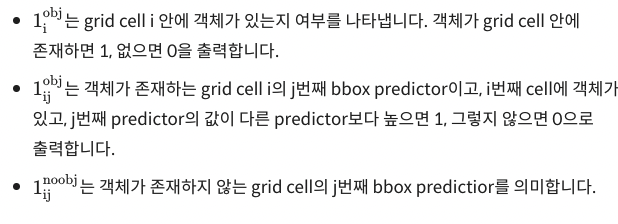

loss 함수를 하나씩 살펴보면 아래와 같다
* 첫번째 항 ~ 세번째 항: 객체가 존재하는 grid cell i의 bbox predictor j에 대해
  * 첫번째 항: x와 y의 loss 계산
  * 두번째 항: 너비와 높이의 loss 계산(제곱근을 취한 SSE)
  * 세번째 항: confidence score의 loss 계산

* 네 번째 항: 객체가 존재하지 않는 grid cell i의 bbox predictor j에 대해 confidence score의 loss 계산(객체가 없을 때의 패널티)
* 다섯번째 항: 객체가 존재하는 grid cell i에 대해 조건부 클래스 확률의 loss 계산

***
### YOLO의 성능

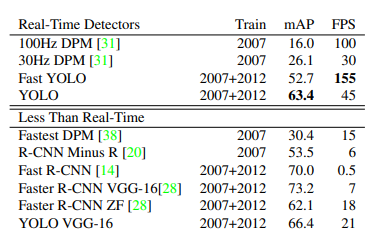

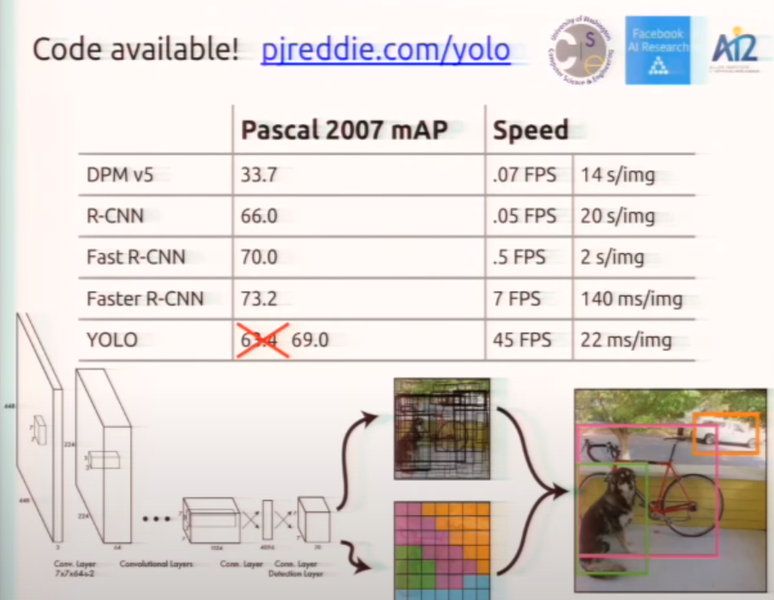

arXiv 논문 발표에서는 mAP가 63.4였지만 CVPR 2016 발표때는 69.0으로 모델의 성능을 향상되어 발표되었다. 즉 YOLO v1은 Faster R-CNN과 성능에 큰 차이가 나지 않으면서 속도는 6배 이상인 혁신적인 연구였다.
***
### YOLO v1의 단점
우선 각각 grid cell이 2개의 box와 하나의 클래스만 예측 가능하므로 가까이에 있는 여러 개의 객체를 예측하기 어려웠다. 특히 새 떼와 같이 그룹으로 나타나는 작은 object에 대해 제대로 예측하지 못했다.

또한 bbox의 형태가 training data를 통해 학습되었기 때문에 bbox 분산이 너무 넓어 새로운 형태의 bbox 예측이 잘 안되기도 했다. 모델 구조상 backbone만 거친 feature map을 대상으로 bbox 정보를 예측하기 때문에 localization이 다소 부정확했다.

마지막으로 loss 함수가 작은 bbox와 큰 bbox의 loss를 같게 다루기 때문에 큰 box의 작은 loss보다 작은 box의 작은 loss가 IoU에 더 큰 영향을 미쳤다. 그래서 2017년 YOLO v2가 나오게 된다.

## YOLO (4) YOLO v2
* YOLO의 목적
  * Make in better
  * Do it faster
  * Makes us stronger

### Make it better
Better은 정확도를 올리기 위한 방법이다. 이전 YOLO v1에서 낮은 성능으로 보였던 localization과 recall을 높이면서도 여전히 모델을 단순하게 만들고 속도도 빠르게 하려고 하였다.

이를 위해 사용한 방법으로, 
1. Batch Normalization
2. High Resolution Classifier
3. Convolutional with Anchor boxes
4. Dimension Clusters
5. Direct location prediction
6. Fine-Grained Features
7. Multi-Scale Training

등의 방법을 사용하였다. 각 방법을 사용했을 때의 결과는 아래 표로 정리되어 있다.

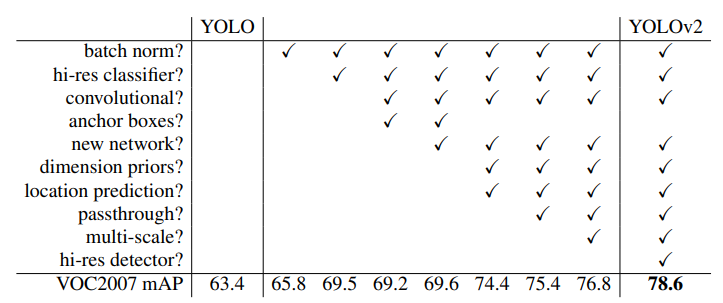

* Batch Normalization

  * 모든 conv 레이어에 batch normalizaion을 사용하였고, dropout은 제거하였습니다. 이로써 mAP에서 2% 이상의 성능 개선을 하였습니다.

* High Resolution Classifier

  * YOLO v1에서 ImageNet의 224 x 224 이미지를 학습하고, detection에서 448 x 448 이미지를 사용했던 것과 달리 YOLO v2에서는 처음부터 448 x 448의 해상도로 학습하였습니다. 이로써 mAP에서 4% 정도의 성능 개선을 이루었습니다.

* Convolutional With Anchor Boxes

  * bounding box를 예측하기 위해 YOLO v1의 Fully connected 레이어를 제거한 후 Fully Convolutional Network를 사용하였고, anchor box들을 사용해 bounding box를 예측하였습니다.
 
 * 또한 1개의 중앙점을 갖는 13 x 13(홀수 x 홀수)의 출력 feature map을 만들도록 입력 이미지의 크기를 448 x 448에서 416 x 416로 줄였습니다. 이는 대부분의 객체가 이미지의 중앙에 있는데, 중앙에 위치한 객체의 경우는 중앙점이 하나일 경우에 더 잘 예측할 것이라는 예상 때문이었습니다.

  * 따라서 YOLO v2는 13 * 13 * 5개의 bounding box를 예측합니다.

  * 그 결과 mAP는 69.5에서 69.2로 떨어지지만 recall은 81%에서 88%로 증가였습니다.

* Dimension Cluster

  * Fast R-CNN에서는 anchor box의 크기와 비율을 사전에 정해주고, 학습을 통해 세부 조정을 했습니다. 그러나.YOLO v2는 k-means clustering을 적용해 최적의 anchor box를 결정하였습니다.

  * 하지만 유클리드 거리를 사용하는 일반적인 k-means clustering과 달리 IoU 개념을 distance metric으로 사용해 더 좋은 anchor box를 얻을 수 있었어요. 그 이유는 ground truth box와 유사한, 즉 IoU가 높은 anchor box를 찾기 위해서였습니다.

  * 클러스터링 개수를 늘리면 정확도가 높아지지만 속도가 느려지므로 YOLO v2는 최종적으로 5개의 anchor box를 사용했습니다.

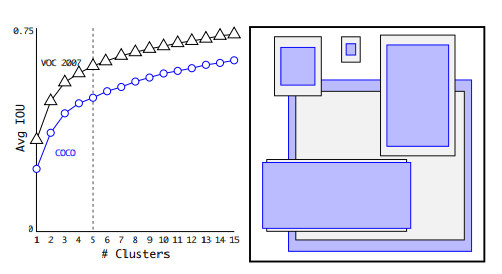


* Direct location prediction
  * YOLO v2는 결정한 anchor box에 따라서 하나의 셀에서 5차원의 벡터로 이루어진 bounding box를 아래와 같은 방식으로 조정하여 예측하였습니다. 
  * 학습 초반에 random initialization으로 인한 학습의 불안정을 예방하기 위해 bounding box가 grid cell을 벗어나지 않도록 제약을 둔거죠. 
  * 주의할 점은 YOLO v1이 grid cell의 중앙점을 예측하였다면 YOLO v2은 좌상단으로부터 얼마나 이동하였는지 예측한다는 것입니다.

  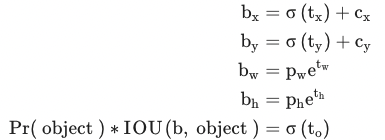

(p_w, p_hp 
w
​
 ,p 
h
​
 : 앵커 박스 사이즈, t_x, t_y, t_w, t_ht 
x
​
 ,t 
y
​
 ,t 
w
​
 ,t 
h
​
 : 모델의 예측 offset 값, b_x, b_y, b_w, b_hb 
x
​
 ,b 
y
​
 ,b 
w
​
 ,b 
h
​
 : 예측 bounding box의 좌표, 너비, 높이)

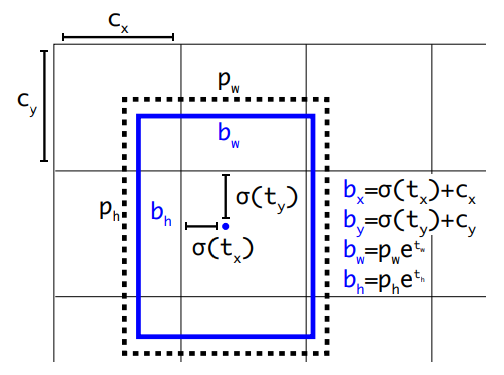

* Fine-Grained Features
  * 13 × 13의 feature map은 작은 물체 검출을 잘 하지 못한다는 단점이 있었기 때문에 YOLO v2는 passingthrough 레이어라는 것을 사용했습니다. 
  * passingthrough 레이어는 이전 레이어의 26 × 26 feature map과 13 × 13의 feature map을 concatenate합니다. 
  * 이렇게 하는 이유는 26 x 26의 feature map에 Fine-Grained Features(고해상도 피처)가 담겨 있기 때문입니다.
  * 그러나 두 feature map의 크기가 다르기 때문에 26 × 26 × 512 feature map을 13 × 13 × 2048 feature map으로 변환한 후 concatenate하였습니다.
  * 이로써 약 1%의 성능 향상을 보였습니다.

* Multi-Scale Training
  * 모델이 다양한 입력 사이즈에도 예측을 잘 할 수 있도록 매 10개의 batch마다 입력 이미지의 크기를 바꿔가면서 모델 학습을 하였습니다. 
  * 모델이 32 간격으로 downsample 되므로 입력 이미지는 32의 배수가 될 수 있습니다. 그래서 입력 이미지의 크기는 {320, 352, ... 608} 중 하나가 사용됩니다.

* Do it faster
  * faster는 detection 속도를 향상시키기 위한 방법이었다.

* Darknet-19
  * YOLO v2에서는 Fully Connected 레이어를 제거하고 global average pooling을 하여 가중치 파라미터 수를 크게 줄였습니다. 
  * 이렇게 해서 만든 최종 모델은 Darknet-19이라고 불리는데, 19개의 convolutional 레이어와 5개의 maxpooling 레이어로 이루어져 있습니다.
  * DarkNet-19를 통과한 YOLO v2의 최종 출력은 13 x 13 x 125이에요. 위에서 feature map이 13 x 13이라고 하였고, 5개의 bounding box를 예측하기 때문에 5 * (5 + 20)이므로 13 x 13 x 125이 됩니다. 
  * 이전 스텝에서 하나의 bounding box가 x, y, w, h, confidence를 예측하고, 클래스의 개수가 20개라고 했던 것 기억하시죠?

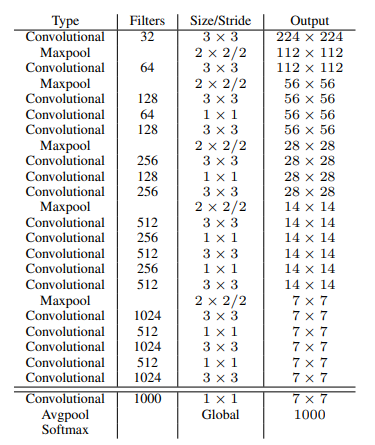


* Makes us stronger
  * stronger는 더 많은 범위의 class를 예측하기 위한 방법이었습니다. 
  * YOLO v1는 PASCAL VOC 데이터셋에서 제공되는 20개의 클래스를 기준으로 학습해서 20개의 클래스만 detection하였습니다. 
  * 그러나 YOLO v2에서는 9천개의 클래스에서 detection할 수 있도록 하고, 그 모델을 YOLO9000이라고 불렀습니다. 
  * 그래서인지 YOLO v2는 YOLO9000: Better, Faster, Stronger이라는 논문 이름으로 발표되었죠.
  * YOLO 9000은 YOLO v2와 모델 구조가 같고 detection하는 라벨을 늘렸기 때문에 자세히 설명하지는 않겠습니다. 
  * 간단히 설명하자면 9천개의 클래스에 대해 분류를 하기 위해 계층적으로 분류 작업(Hierachical Classification)을 수행하여 기존의 WordNet 기반의 데이터를 트리 구조인 WordTree를 생성하였습니다.

  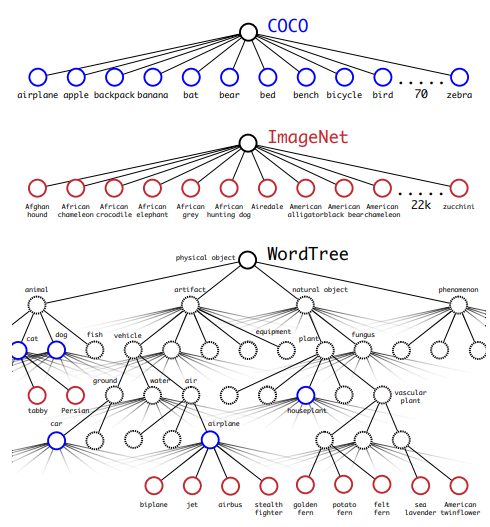

## 13.7 YOLO (5) YOLO v3


YOLO v3는 v2보다 속도는 느리지만 정확도를 개선한 모델이다. 특히 YOLO의 약점이었던 작은 물체를 detection할 때 성능을 개선하였다.
> 이전 YOLO모델과의 차이점: https://arxiv.org/abs/1804.02767

### YOLO v2와의 차이점
* Bounding Box Prediction
  * Bounding Box Prediction은 YOLO v2와 거의 차이가 없지만, 각각의 bounding box마다 objectness score, 즉 bounding box에 물체가 있는지를 예측하는 점수를 logistic regression을 사용해 예측하였다. anchor box와 ground truth box의 IoU가 가장 높은 박스의 objectness score는 1로 두고 나머지는 무시하였다. 또한 Faster R-CNN 등의 다른 모델과 달리 각각의 ground truth에 대해 1개의 bounding box만 가지게 된다는 차이가 있었다.

  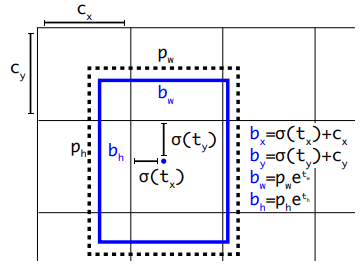

* Class prediction
  * YOLO v3는 하나의 이미지에 다양한 label을 붙일 수 있는 multilabel classification를 하였습니다. 예를 들어 여성의 이미지에 person과 woman이라는 두 가지의 label을 붙일 수 있는 것을 의미합니다. 이를 위해 여러 개 중 하나만 찾는 softmax classifier가 아닌 해당 label이 맞는지 아닌지를 판단하는 logistic classifier를 사용하였고, binary cross entropy를 사용해 loss를 계산하였습니다.
* Prediction Across Scales
  * YOLO v3은 3개의 scale로 bouding box를 예측하였고, 각 scale당 3개의 bouding box를 예측하였습니다. 따라서 총 9개의 bouding box가 나오게 되며, 텐서는 N × N × [3 ∗ (4 + 1 + 80)]입니다. 여기서 3은 anchor box의 수이고, 4는 bounding box의 좌표, 너비, 높이이며, 1은 objectness score, 그리고 80의 클래스의 수입니다.
  * 또한 feature map을 2배씩 upsampling함(13, 26, 52)으로써 더 의미 있는 semantic information을 얻고, 이전 feature map과 concatenate하여 보다 fine-grained한 정보를 얻을 수 있었다고 합니다.
* DarkNet-53
  * 성능을 높이기 위해 YOLO v3은 53개의 레이어를 사용하였습니다. YOLO v2의 아키텍처였던 DarkNet-19에 residual network를 넣어 레이어를 53개까지 쌓을 수 있었습니다.

  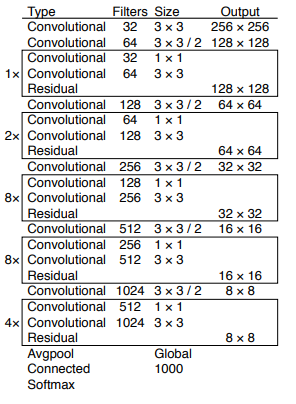

DarkNet-53은 DarkNet-19보다 정확도가 높았고, ResNet-101이나 ResNet152과 성능이 비슷하지만 연산면에서 효율적이었습니다.

  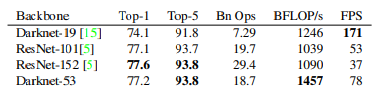

전체 모델 구조는 아래의 이미지로 나타낼 수 있습니다. 입력 이미지를 DarkNet-53에 통과시켜서 downsampling하면서 feature map을 추출합니다. 이 feature map을 토대로 detection을 하고, upsampling 후 다시 detection하고 다시 upsampling을 한 후에 detection하게 됩니다. 즉 3개의 scale된 bounding box를 이용한 detection을 함으로써 여러 개의 label에 대해서도 classification을 할 수 있었습니다.

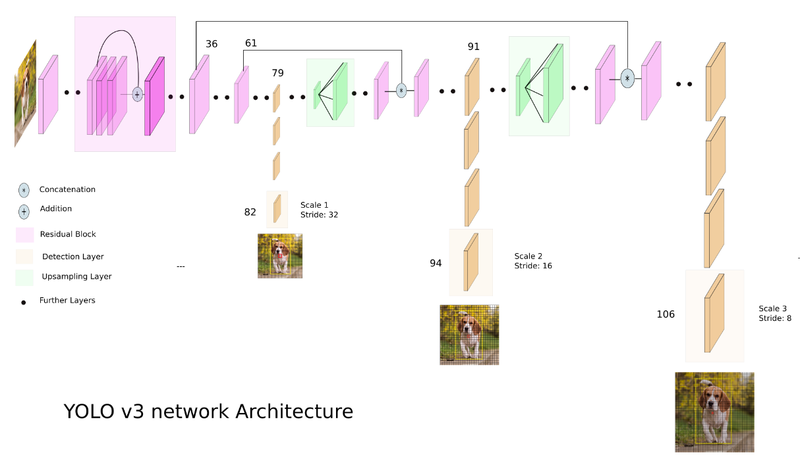

## YOLO v3 그 이후
Redmon은 Computer Vision 연구가 자신의 목적과는 다르게 군사적으로 사용되고 있는 것에 큰 회의감을 느끼고 CV 연구를 그만두겠다고 선언합니다. YOLO 등 DarkNet 프로젝트는 Alexey Bochkovskiy가 메인테이너로 이어 받게되죠. 그 이후에도 다양한 사람들에 의해 YOLO를 이용한 다양한 모델이 나왔습니다.

### YOLO v4

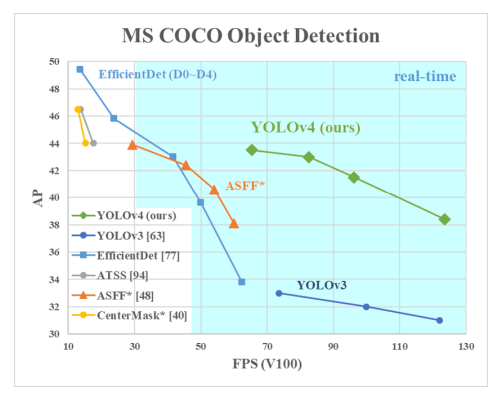

YOLO v4을 간단히 설명하자면 YOLO v3에 다양한 기법을 사용해 하나의 GPU(1080 Ti 또는 2080 Ti)로 object detection을 실시간으로 할 수 있도록 만든 모델입니다. 논문에서도 다양한 기법을 소개하고, 그 기법들을 실험한 결과를 정리하여 YOLO v4라는 모델을 만들어 냈습니다. 따라서 YOLO v4를 아래와 같이 나타낼 수 있습니다. 백본으로는 CSPDarknet53을 사용하였고, Neck(feature map 정제 및 재구성)으로는 SPP와 PAN, Head(object classification, localization)에서는 YOLO v3를 사용한 거죠.

> YOLO v4 = YOLO v3+ CSPDarknet53 + SPP + PAN(Path Aggregation Network) + BoF(Bag of Freebies) + Bos(Bag of Specials)

참고로 Bag of Freebies는 Inference cost의 변화 없이 성능을 향상시키는 방법으로 전처리 또는 학습 단계에서 사용됩니다. Data Augmentation, Regularization, Loss Function 등이 이 기법에 속합니다. Bag of Specials는 inference cost가 조금 상승하면서 성능을 향상시키는 방법으로, Inference 단계나 후처리 단계에서 사용됩니다. Enhance Receptive field, Feature Integration, Activation function, Attention Module, Normalization, Post Processing 등이 해당됩니다.

> YOLO v4 논문: https://arxiv.org/pdf/2004.10934.pdf



### YOLO v5

YOLO v5는 2020년 6월에 YOLO v3을 PyTorch로 구현한 Glenn Jocher에 의해 발표되었습니다. 하지만 YOLO v5는 처음으로 논문과 함께 발표되지 않은 최초의 모델이자, DarkNet이 아닌 PyTorch로의 구현이므로 기존의 YOLO 모델과 많이 다르다는 이유로, YOLO v5라는 이름에 대해 논란이 있었던 모델입니다. YOLO v5의 코드는 Ultralytics LLC라는 회사의 깃헙에 공개되어 있습니다.

YOLO v4와 성능은 비슷하지만 용량이 훨씬 작고 속도도 빠릅니다.

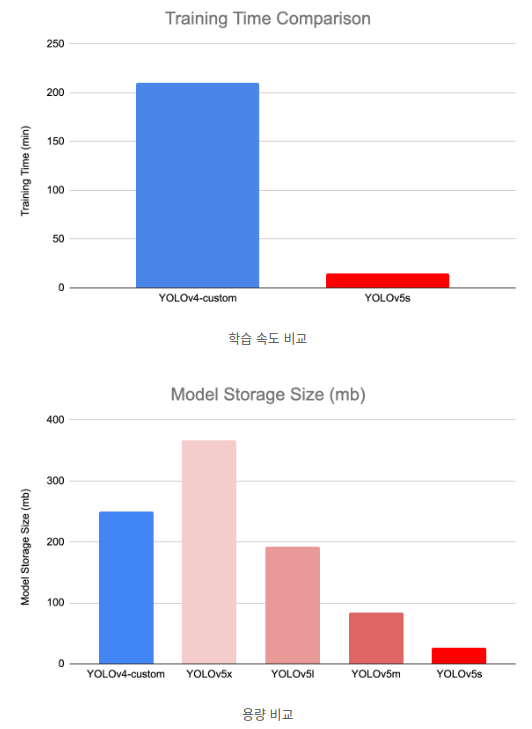

* YOLO v5의 종류
  * OLOv5s
  * YOLOv5m
  * YOLOv5I
  * YOLOv5x
각각 small, medium, large, xlarge로, 백본이나 head는 동일하지만 모델 깊이와 레이어의 채널 수가 다릅니다. YOLOv5s는 (0.33, 0.50), YOLOv5m은 (0.67, 0.75), YOLOv5l은 (1.0, 1.0), YOLOv5x는 (1.33, 1.25)의 비율이며, 그에 따른 성능은 아래와 같이 s가 가장 빠르고, 정확도는 x가 가장 높습니다.

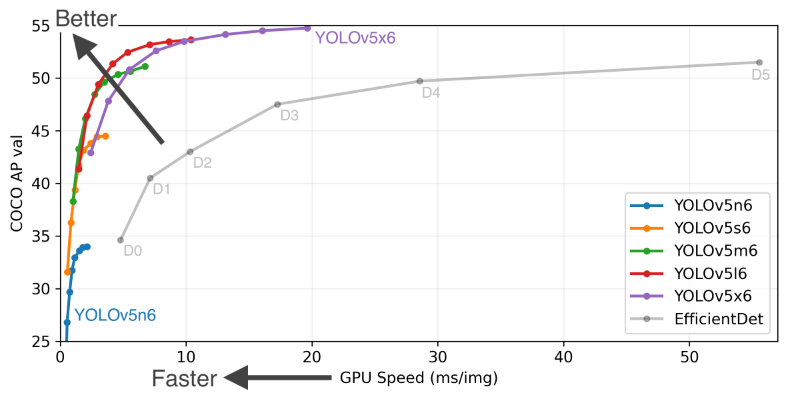

YOLO v5는 YOLO v4의 백본과 유사하게 CSP-Darknet을 사용하고, YOLO v3과 동일하게 3가지 scale에서 bounding box를 각각 3개씩 찾습니다. YOLO v5의 아키텍처에 대한 자세한 설명은 아래의 블로그를 참고하세요.
> YOLO v5 환경 셋팅 및 모델 아키텍쳐 분석: https://ropiens.tistory.com/44

### PPYOLO
PPYOLO는 2020년 8월에 바이두에서 발표된 모델로, PP라는 것은 바이두에서 만든 오픈 소스 딥러닝 전용 프레임워크 PaddlePaddle의 약자입니다. 즉 PPYOLO는 PaddlePaddle을 이용해 구현한 YOLO 계열의 모델입니다. PPYOLO를 소개한 논문 PP-YOLO: An Effective and Efficient Implementation of Object Detector은 YOLO v4와 비슷하게, 좋다고 알려진 다양한 기법을 사용해 YOLO v3의 성능을 올린 과정을 소개한 논문이죠.
> 논문: https://arxiv.org/pdf/2007.12099.pdf

그러나 YOLO v4와 달리 백본 네트워크, Data augmentation, NAS 등은 사용하지 않았는데, 그 이유는 일반적인 방법을 사용해 YOLO v3의 성능을 올리기 위해서라고 합니다. 만약 YOLO v4에서 사용한 기법을 사용하면 PPYOLO의 성능은 더 좋아질 것이라고 하네요.

PPYOLO의 기본 구조는 YOLO v3와 거의 동일합니다. 다만 다른 것은 백본을 DarkNet-53 대신 ResNet50-vd를 사용한 것과 Inject Points 3가지가 추가로 적용된다는 것입니다.

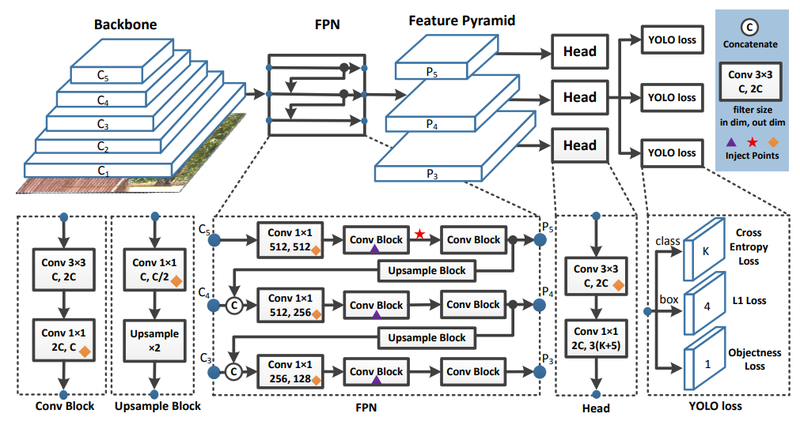

PPYOLO에서는 YOLO v4와 비슷하게 Larger Batch Size, EMA, DropBlock Regularization, SPP 등 다양한 방법을 사용해 실험을 하였는데요, 자세한 내용은 논문을 참고해 보세요.

PPYOLO의 성능은 YOLO v4보다 정확도와 속도가 높습니다.

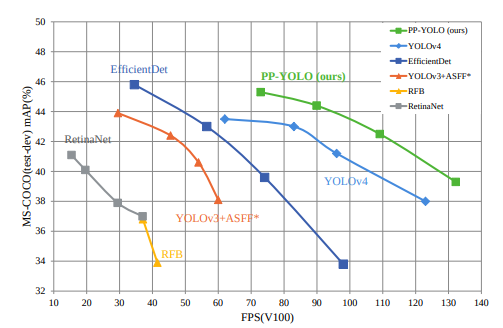

### Scaled YOLO v4
2020년 11월, YOLO v4에 scaling 기술을 적용한 Scaled YOLO v4가 공개되었습니다. Scaled YOLO v4는 다양한 디바이스 환경에서 실시간으로 객체를 탐색하면서도 높은 정확도를 갖출 수 있도록 모델에 scaling 기술을 YOLO v4에 적용하였는데요, YOLO v4 -> YOLOv4-CSP-> Scaled YOLO v4의 순서로 모델을 만들었다고 합니다. YOLO v4에 CSP를 적용한 이유는 기존 모델에 CSPNet을 적용하면 FLOPs(FLoating point Operations Per Second)을 현저히 줄일 수 있기 때문이었습니다. 또한 모델의 scaling의 상한과 하한을 정해 YOLOv4-large와 YOLOv4-tiny model을 만들었습니다.

아래의 그림은 YOLO v4-large의 아키텍처입니다. 먼저 CSP를 완전히 적용한 YOLOv4-P5를 디자인한 후, 이를 스케일링 업하여 -P6, -P7 버전을 만들었다고 하네요.

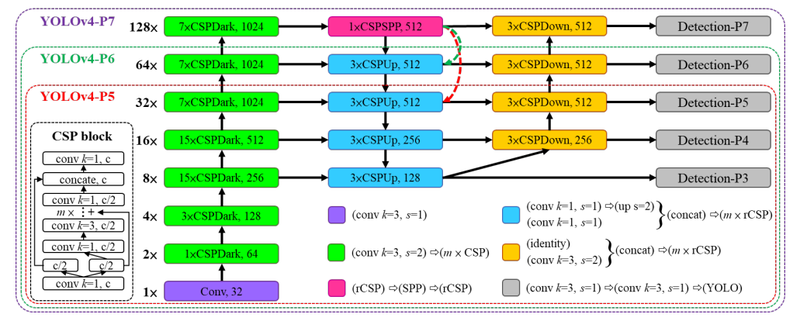

Scaled YOLO v4는 발표 당시 기존의 object detection 분야에서 가장 좋은 성능을 가지고 있었습니다. Scaled YOLO v4에 대한 자세한 내용은 논문 Scaled-YOLOv4: Scaling Cross Stage Partial Network을 참고하세요.
> 논문: https://arxiv.org/pdf/2011.08036.pdf

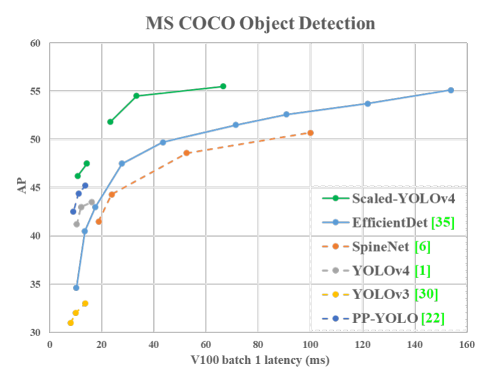

### PPYOLO v2

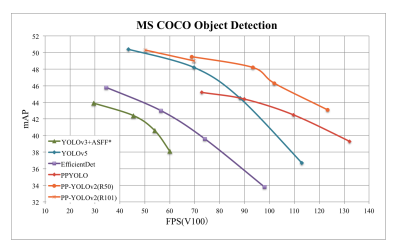

PPYOLO v2는 PPYOLO의 성능을 향상시키기 위해 mish 활성화 함수와 Path Aggregating Network 등 다양한 실험을 했다고 하는데요, 
> https://arxiv.org/pdf/2104.10419.pdf

### YOLOR
2021년 5월에 YOLOR이 논문 You Only Learn One Representation: Unified Network for Multiple Tasks에서 소개되었습니다. YOLOR은 Scaled YOLO v4에서 파생된 모델로 같은 저자에 의해 쓰여졌습니다.
> https://arxiv.org/pdf/2105.04206.pdf

YOLOR은 사람이 학습할 때 명시적 지식(explicit knowlege)과 암묵적 지식(implicit knowlege)를 사용한다는 것에서 착안하여 만들어진 모델입니다. 참고로 명시적 지식은 말과 글로 표현할 수 있는 지식이고, 암묵적 지식은 문자나 언어가 아닌 경험이나 학습에 의해 체득된 지식입니다. YOLOR은 사람의 일반적인 학습 과정을 딥러닝에 적용하여 general representation을 생성하는 통합된 네트워크를 구성하였습니다. 이로써 YOLOR은 멀티 태스크를 잘 수행할 수 있었죠.

YOLOR의 아키텍처는 단순한데, YOLO v4 CSP 모델의 feature alignment, prediction refinement, multitask에 암묵적 지식을 아래와 같이 더해주는 것입니다. 암묵적 지식의 형태나 어떻게 모델에 적용되는지는 논문을 참고해 보세요.

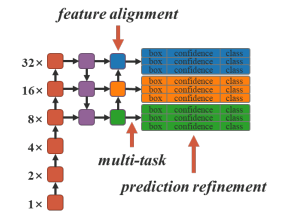

### YOLOX

2021년 8월에 나온 YOLOX: Exceeding YOLO Series in 2021는 Anchor-Free Detector, Advanced Label Assignment Strategy, End-to-end Detector 등의 최신 연구를 적용하여 YOLO v3 SPP의 성능을 개선하였습니다.

아래 그림은 베이스라인으로 사용한 YOLO v3과의 차이를 나타내고 있는데요, YOLOX는 특히 Decoupled Head, Strong Data Augmentation, Anchor-Free, Multi-positives를 통해 성능 향상을 꾀하고 있습니다. Decoupled Head는 prediction하고자 하는 값에 따라 Head를 나누어 학습 속도를 빠르게 했고, Detector를 End-to-End 방식으로 만들 수 있었습니다.

Anchor-Free는 ground truth box 와 생성된 bounding box 안의 cell이 겹쳐 있으면 positive, 아니면 negative로 지정하여 detection을 수행합니다. 이로 인해 연산량을 낮추고, 일반화를 시킬 수 있으며 class imbalance 문제도 해결하고, 정확도를 높일 수 있다고 하네요.

그러나 Anchor-Free 방식만으로는 Anchor 메커니즘의 정확도를 따라잡을 수 없었기 때문에 Multi-positives를 사용하였습니다. Multi-positives는 각 객체의 중심과 주변에 해당하는 cell을 positive로 할당하여 예측을 하는 방법으로, 낮은 loss를 가진 k개의 cell만 학습에 참여시키는 simOTA과 함께 사용하여 정확도를 향상시켰습니다. YOLOX에 대해 더 자세한 내용은 논문을 참고해 보세요.

> https://arxiv.org/pdf/2107.08430.pdf

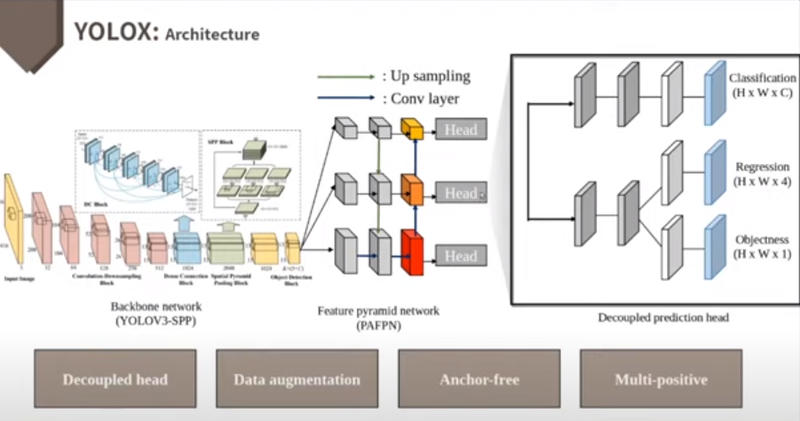

### YOLOS
NLP 분야에서 큰 영향을 끼치고 있는 Transformer는 CV에서도 점차 영향력을 키우고 있습니다. 이런 흐름에 맞춰 2021년 10월 You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection라는 논문에서 YOLOS라는 모델이 소개되었습니다. 즉 YOLOS는 Transformer Encoder와 NLP Heads만을 사용해 2D object detection을 수행한 모델입니다.

YOLOS의 성능은 최근에 나온 다른 YOLO 게열의 모델과 비교했을 때 아주 좋지는 않은데요, YOLO v3이나 RetinaNet와 비슷한 정도의 성능을 보이고 있습니다. 하지만 Transformer를 object detection에 적용했다는 점에서 주목해볼만 하죠?

아래의 그림은 YOLOS의 모델 구조입니다. 간단히 설명하자면 YOLOS는 Transformer와 DETR의 Bipartite Loss를 합친 모델입니다. 자세한 내용은 논문을 참고해 보세요.
> https://arxiv.org/pdf/2106.00666.pdf

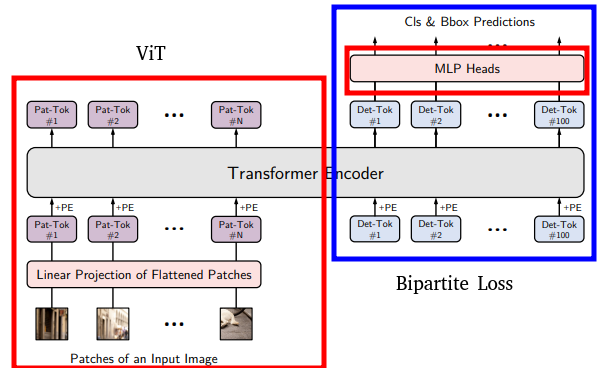

## 13.9 SSD (1) SSD의 특징
SSD는 YOLO v1에서 grid를 사용해서 생기는 단점을 해결할 수 있는 몇 가지 테크닉을 제안했다
* Pre-defined Anchor Box
* Image Pyramid
> https://arxiv.org/pdf/1512.02325.pdf



### SSD의 Workflow
YOLO v1의 두번째 단점은 box 정보 (x, y, w, h)를 예측하기 위한 seed 정보가 없기 때문에 넓은 bbox 분포를 모두 학습할 수 없었다는 점입니다. 이로 인한 성능 손실이 존재할 수 있었죠. 따라서 Faster R-CNN 등 에서 사용하는 anchor를 적용할 필요가 있었습니다.

만약 개가 등장하는 bounding box가 존재한다면, 그 bounding box만의 x, y, w, h 특성이 존재하기 때문에 pre-defined된 box의 x, y, w, h를 refinement하는 layer를 추가하는 것이 이득이었습니다. 이 anchor box를 SSD에서는 Default box라고 부릅니다

### Image Pyramid

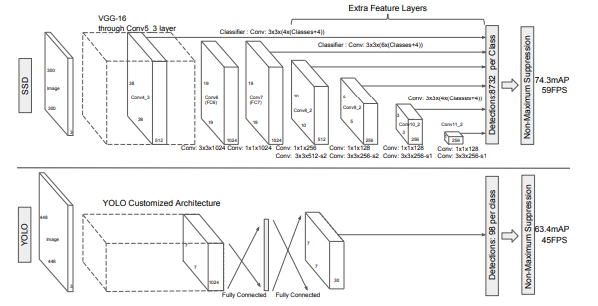

Image Pyramid는 ImageNet으로 사전학습된 VGG16을 사용합니다. VGG에서 pooling layer를 거친 block은 하나의 image feature로 사용 가능합니다.

YOLO에서 7x7 크기의 feature map 하나만을 사용했다면, SSD는 38 x 38, 19 x 19, 10 x 10, 5 x 5, 3 x 3, 1 x 1인 다양한 크기의 feature map을 사용하였습니다. 각 feature map은 YOLO의 관점에서 보면 원본 이미지에서 grid 크기를 다르게 하는 효과가 있었습니다. 따라서 5 x 5 크기의 feature map에서 grid가 너무 커서 작은 물체를 못찾는 문제를 38 x 38 크기의 feature map에서 찾을 수 있는 단서를 마련하였습니다.

즉 SSD는 서로 다른 크기의 feature map에서 object detection을 해서 작은 물체는 큰 feature map에서, 큰 물체는 작은 feature map에서 찾을 수 있게 한 거죠. 각 단계에서 추출된 feature map은 detector와 classifier를 통과해 object detection을 합니다.

각 feature map에는 bounding box와 클래스 정보가 담겨 있는데, 이 feature map들을 2번 convolution합니다. 위의 그림에서 보면 Classifier: Conv: ...라고 쓰여있는 부분에서 1번 더 convolution을 하게 되죠. 3 x 3 x (default box의 수 x (class의 수 + 4)의 가중치로 convolution을 하여 n x n x (default box의 수 x (class의 수+4))의 feature map을 얻게 됩니다. 여기서 class는 PASCAL VOC의 클래스 20개와 배경 클래스를 합해 21이고, + 4는 bounding box의 위치 정보 x, y, w, h의 개수를 의미합니다.

아래의 그림은 위의 그림에서 생략되었던 detector와 classifier를 포함한 아키텍처를 보여줍니다. 각각의 feature map에서 뽑아낸 6개의 classifier의 예측을 NMS를 사용해 confidence가 가장 높은 box 하나만 남겨 최종 detection을 합니다.

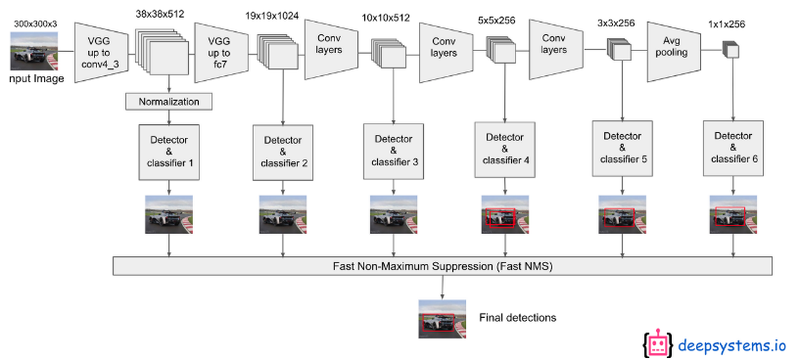

> **Q4. Image feature pyramid의 단점은 무엇인가요?**
>
> A. YOLO와 비교하였을 때 최소 feature map의 개수만큼 계산량이 많다. 38 x 38 크기의 feature map은 box를 계산하기에는 충분히 깊지 않은 network일 수 있다.

### SSD의 framework

SSD는 입력 이미지와 각 객체에 대한 ground truth box만을 필요로 합니다. convolution을 할 때 비율이 다른 default box를 설정하는데, 아래의 그림은 다른 크기의 feature map에서, 각 객체마다 다른 비율의 default box를 4개씩 만들어 놓은 것을 표현한 것입니다. 각 default box에서 default box와 대응되는 bounding box regression을 적용하여 box의 (x, y, w, h)를 찾고 confidence, 즉 box 안에 물체가 있는지 없는지를 예측하는 점수를 예측합니다.

학습할 때 이 default box와 ground truth box를 비교해 ground truth box와 비슷한 default box를 선택하여 positive, 나머지는 negative로 설정합니다. 고양이는 개보다 작기 때문에 8 x 8 feature map에서는 고양이를 잡아내고, 4 x 4 feature map에서는 개를 잡아낸 것을 볼 수 있습니다.

이렇게 각 레이어에서 피쳐 맵들을 가져와 Object Detection을 수행한 결과들을 모두 합하여 localization loss와 confidence loss를 구한 다음, 전체 네트워크를 학습시키는 방식으로 1 Step end-to-end Object Detection 모델을 구성하였습니다.

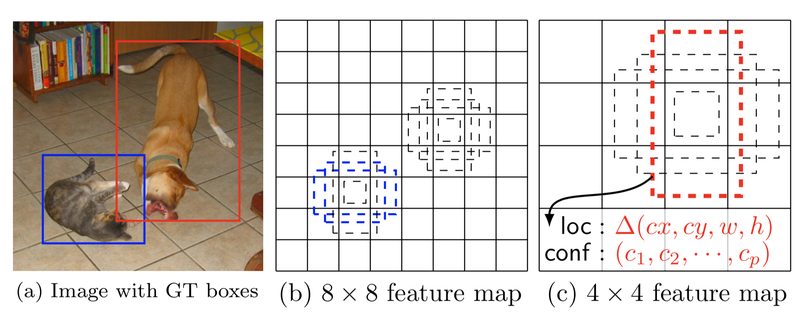

### Default box를 위한 scale
다양한 크기의 Default box 생성을 위해 SSD는 아래와 같은 식을 사용합니다.
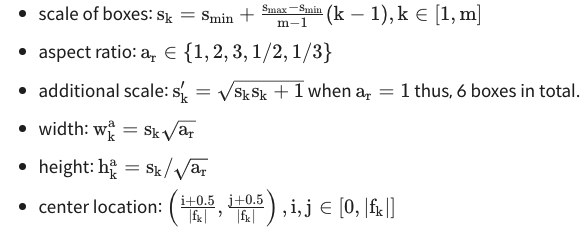

feature map의 개수를 m, S_{min}S 
min
​
 을 0.2, S_{max}S 
max
​
 를 0.9라고 하고, 위의 식에 넣으면 각 feature map당 서로 다른 6개의 s 값(scale 값) [0.2, 0.34, 0.48, 0.62, 0.76, 0.9]이 나옵니다. 이 값은 각 feature map에서 default box의 크기가 입력 이미지의 너비와 높이에 비해 얼마나 큰 지를 보여줍니다.

여기서 aspect ratio를 {1, 2, 3, 1/2, 1/3}로 설정하여 default box의 너비와 높이를 구할 수 있습니다. 예를 들어 k=3이라면 scale은 0.48이며 aspect ration가 2라면 너비는 0.64, 높이는 0.34입니다. 논문에서는 1개의 box를 더 추가해 총 6개의 default box의 너비와 높이 값을 구합니다.

입력 이미지에서 default box가 위치할 중심점(center location)의 식에서 f_kf 
k
​
 는 k번째 feature map의 크기입니다. 대략 예측되는 상자가 정사각형이나 가로로 조금 길쭉한 상자, 세로로 조금 길쭉한 상자이기 때문에 2:3으로 임의로 정해도 학습이 잘 되지만, 특이한 경우, 즉 가로 방향으로 걸어가는 지네와 같은 경우에 위의 비율로 정하면 threshold를 0.5로 했을 때 학습이 되지 않습니다. 따라서 학습할 이미지에 따라서 aspect ration를 조정해야 합니다. 임의로 정하는 것은 비효율적이므로 KNN과 같은 알고리즘을 활용하면 좋은 결과가 나올 것입니다.

이렇게 구해준 중심점 좌표들에 원래의 입력 이미지의 크기를 곱해 중심점을 구하고, 각 중심점마다 default box를 그릴 수 있습니다. 이를 시각화하면 아래와 같습니다.

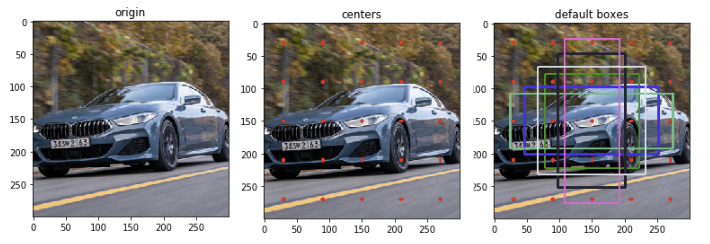

## 13.13 SSD (2) SSD의 Loss와 성능

### Matching strategy
학습 전에 ground truth와 defalt box의 jaccard overlap(IoU)이 0.5 이상인 것을 미리 매칭시켜 positive sample로 설정합니다. jaccard overlap이 0.5 이상인 default box를 모두 사용하면 학습 문제를 단순화시켜서 더 높은 성능을 가져올 수 있습니다.
> jaccard overlap(IoU): https://en.wikipedia.org/wiki/Jaccard_index

### SSD Loss Function

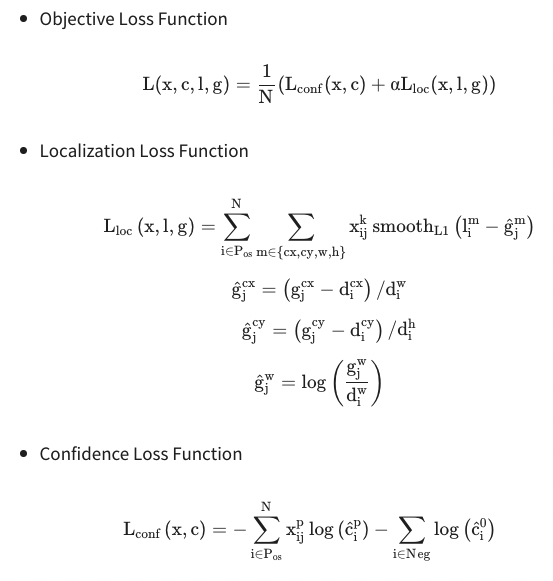


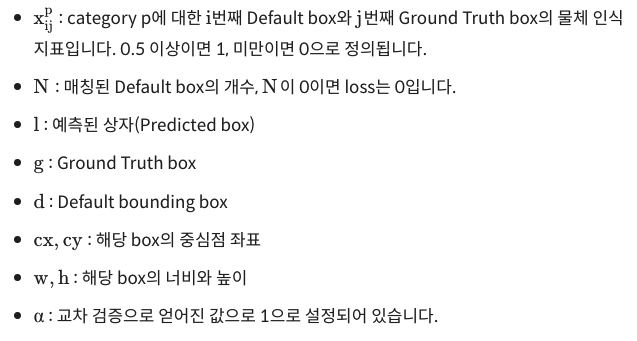

* Object Loss Function
  * 전체 로스는 각 클래스 별로 예측한 값과 실제값 사이의 차이인 L_{conf}L 
conf
​
 와 bounding box regression 예측값과 실제값 사이의 차이인 L_{loc}L 
loc
​
 를 더한 값입니다.

* Localization Loss Function

  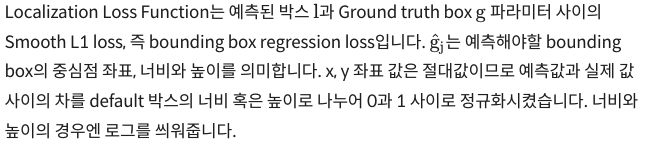

* Confidence Loss Function

  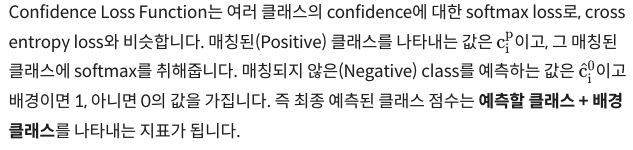

* Hard negative mining

  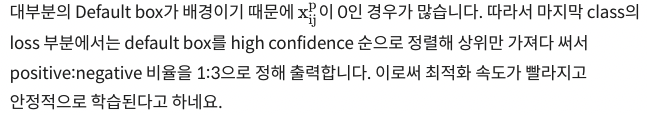

* SSD의 성능
  * SSD의 성능은 아래와 같이 Faster R-CNN보다는 성능이 조금 낮지만 속도는 빠르고, YOLO보다는 성능이 높고 속도는 느립니다. SSD가 속도와 정확성을 동시에 잡자는 목표를 갖고 있었다는 것을 생각해보면, 그 목표를 이룬 것 같죠?

  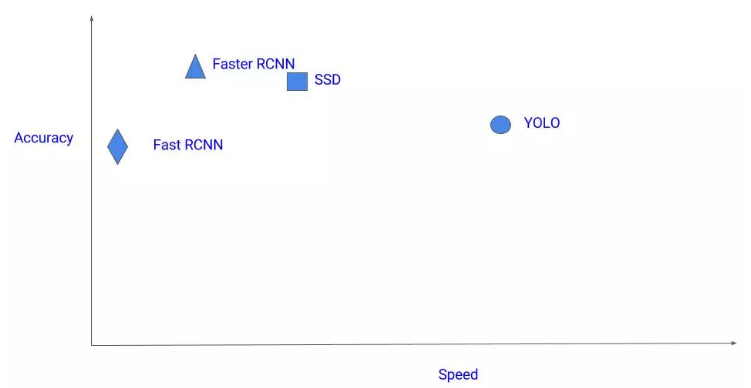

YOLO가 작은 물체를 잘 찾아내지 못했던 것 역시 SSD에서는 어느 정도 해결한 것 같습니다. 심지어 YOLO v2보다 성능이 더 좋다는 것을 알 수 있습니다.

  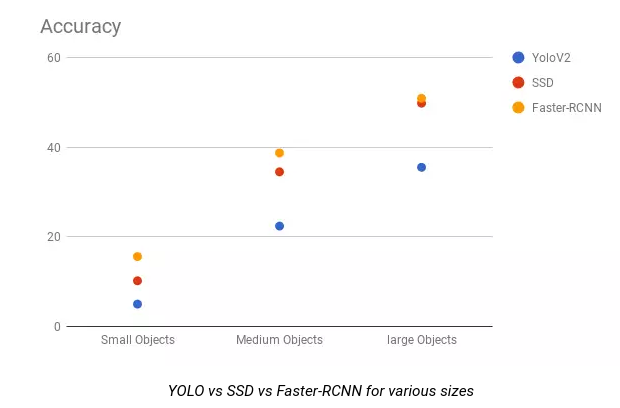

* FCOS
> https://arxiv.org/pdf/1904.01355.pdf

FCOS:Fully Convolutional One-Stage Object Detectionan는 기존의 anchor box기반에서 벗어나 pixelwise로 예측하는 FCOS를 제안했습니다. Anchor box를 사용하면서 생기는 부작용(예: 학습 계산량, 하이퍼파라미터에 민감한 성능 등)을 해결하면서도 좋은 성능을 보입니다.

> 참고: https://blog.naver.com/jinyuri303/221876480557

## 13.11 Face Detection을 위한 모델들
SSD 이후로 특히 Face Detection 모델이 지속적으로 발표되었습니다. papers with code에서 검색하면 Face Detection에 대한 다양한 모델을 살펴볼 수 있습니다.
> https://paperswithcode.com/task/face-detection

### TinaFace
> https://arxiv.org/pdf/2011.13183v3.pdf

논문 TinaFace: Strong but Simple Baseline for Face Detection에서는 Face Detection과 Object Detection이 다르지 않다는 점을 지적하면서, Object Detection에서 사용했던 기법을 사용해 단순하지만 좋은 성능을 보이는 모델인 TinaFace를 소개합니다. TinaFace는 백본으로 ResNet50을 사용했고 기존에 존재했던 모듈(Feature Pyramid Network, Inception block, FCN 등)을 활용해 만들어졌습니다. 자세한 내용은 논문을 참고해 보세요.

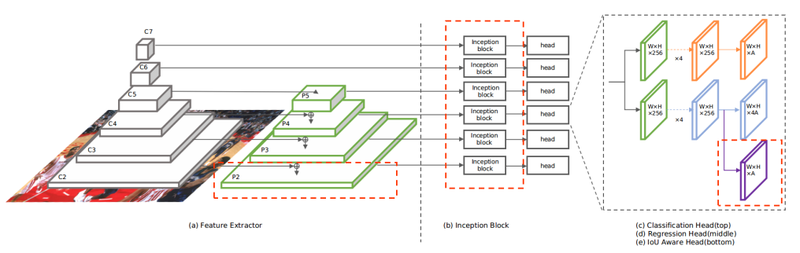

### RetinaFace
> https://arxiv.org/pdf/1905.00641.pdf

RetinaFace는 1-Stage face detector로서, 다양한 얼굴 크기에 대해 pixel-wise face localization을 수행했습니다. 이를 위해 기존의 box classification과 regression 브랜치와 함께 extra-supervised and self-supervised multi-task learning을 하였다고 합니다. 그 결과는 아래의 그림에 나와 있듯 face score, face box, 5개의 얼굴 랜드마크, 3D face vertices(정점)라고 하네요. 자세한 내용은 논문 RetinaFace: Single-stage Dense Face Localisation in the Wild을 참고해 보세요.

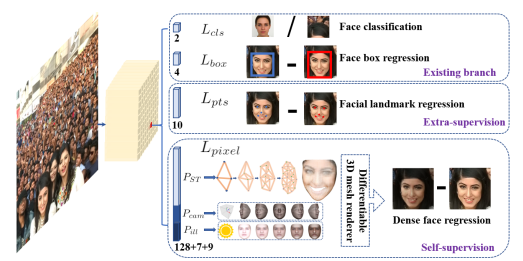

### DSFD
> https://arxiv.org/pdf/1810.10220.pdf

DSFD는 Feature Enhance Module(FEM), Progressive Anchor Loss(PAL), Improved Anchor Matching (IAM)라는 기법을 사용해 성능을 높인 모델인데요, 언급한 세 기법이 two-stream으로 디자인되어 있어서 Dual Shot Face Detector라는 이름이 붙었다고 합니다. 자세한 내용은 논문 DSFD: Dual Shot Face Detector을 참고해 보세요.

### S3FD
> https://arxiv.org/abs/1708.05237

S3FD는 하나의 deep neural network를 사용해 다양한 얼굴 크기에 대해 face detection을 수행하며, 특히 작은 얼굴을 잘 찾는 모델입니다. 다양한 크기의 얼굴을 잘 찾기 위해 layer의 넓은 범위에 anchor를 바둑판 형식으로 배열하였고, anchor 크기도 새롭게 디자인했다고 합니다. 그 외에도 작은 얼굴을 잘 찾기 위해 다양한 기법을 사용했다고 하는데요, 자세한 내용은 논문 S3FD: Single Shot Scale-invariant Face Detector을 참고해 보세요.